In [ ]:
# Para manipulação e análise de dados
import pandas as pd
import numpy as np
import json

# Para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# analise
import spacy
from spacy.tokens import DocBin
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Para salvar o modelo treinado
import pickle


import json
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter


from sklearn.model_selection import train_test_split
from collections import Counter

In [2]:
dataset = 'loja_eletronico.json'
caminho_dataset = f'../datasets/{dataset}'
nlp = spacy.load("pt_core_news_md")

PERCENTUAL_TREINO = 0.7  
RANDOM_STATE = 42

# --- CONFIGURAÇÃO PARA O TREINO ---
EPOCAS = 30          # Número MÁXIMO de épocas. O treino pode parar antes.
PATIENCE = 5         # Número de épocas para esperar sem melhora no F1-Score antes de parar.

In [3]:
# --- Carregamento ---
with open(caminho_dataset, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Criar rótulos para estratificação geral
stratify_labels = [
    f"{item['intent']}_{'_'.join(sorted(set(e['entity'] for e in item.get('entities', [])))) or 'NO_ENTITY'}"
    for item in data
]

# --- Divisão Principal: Treino vs. Teste Geral (que será subdividido) ---
dados_treino, dados_teste_geral = train_test_split(
    data,
    train_size=PERCENTUAL_TREINO,
    random_state=RANDOM_STATE,
    stratify=stratify_labels
)

# --- Divisão do Teste Geral: 50% para `dados_dev` e 50% para um novo conjunto ---
stratify_labels_teste = [
    f"{item['intent']}_{'_'.join(sorted(set(e['entity'] for e in item.get('entities', [])))) or 'NO_ENTITY'}"
    for item in dados_teste_geral
]

# `dados_dev` mantém seu nome original, e o novo conjunto é criado a partir da outra metade
dados_dev, dados_teste_nao_visto = train_test_split(
    dados_teste_geral,
    test_size=0.5, # Divide o conjunto de teste exatamente ao meio
    random_state=RANDOM_STATE,
    stratify=stratify_labels_teste
)

# --- Verificação da Distribuição (como no seu código original) ---
df_treino = pd.DataFrame(dados_treino)
df_dev = pd.DataFrame(dados_dev) # Agora `df_dev` representa apenas a primeira metade do teste
df_test = pd.DataFrame(dados_teste_geral)
def contar_valores(df):
    return Counter(v['value'] for ents in df['entities'].dropna() for v in ents)

contagem_treino = contar_valores(df_treino)
contagem_dev = contar_valores(df_dev)

df_dist_valores = pd.DataFrame({
    'Contagem Treino': pd.Series(contagem_treino),
    'Contagem Dev': pd.Series(contagem_dev)
}).fillna(0).astype(int).sort_index()
display(df_dist_valores)
# O restante do seu código usará:
# 1. dados_treino (para treinar)
# 2. dados_dev (para o teste "visto", a primeira metade)
# 3. dados_teste_nao_visto (para o teste "não visto", a segunda metade)

,Contagem Treino,Contagem Dev
Dell XPS 15,12,2
Galaxy S25 Ultra,10,3
HP Spectre x360,12,3
MacBook Air M4,12,1
Nintendo Switch OLED,10,4
...,...,...
violões,1,0
wearables,1,0
webcams,1,0
áudio e vídeo,0,1


In [4]:
# Célula 4 - Código Completo e Corrigido

import spacy
import random
import json
from spacy.training.example import Example
from spacy.scorer import Scorer

# --- 1. CONVERSÃO DOS DADOS JÁ SEPARADOS ---

# Função auxiliar para converter o formato para o que o spaCy precisa
def converter_para_formato_spacy(dados):
    dados_formatados = []
    for item in dados:
        texto = item['text']
        entidades_validas = []
        for ent in item.get('entities', []):
            # ===================================================================
            # MUDANÇA CRUCIAL AQUI:
            # Só adiciona a entidade se ela tiver os índices 'start' e 'end'.
            # Isso garante que apenas entidades textuais sejam usadas para o treino do NER.
            # ===================================================================
            if 'start' in ent and 'end' in ent:
                entidades_validas.append((ent['start'], ent['end'], ent['entity']))
        
        # Só adiciona o exemplo se ele tiver entidades válidas para o treino
        if entidades_validas:
            dados_formatados.append((texto, {"entities": entidades_validas}))
            
    return dados_formatados

# Agora usamos as variáveis que você já criou: dados_treino e dados_dev
TRAIN_DATA = converter_para_formato_spacy(dados_treino)
DEV_DATA = converter_para_formato_spacy(dados_dev)
TRAIN_FINISH = converter_para_formato_spacy(dados_teste_nao_visto)

# --- 2. CONFIGURAÇÃO DO MODELO (Fine-Tuning) ---
DIRETORIO_SAIDA = f"../models/{dataset.replace('.json', '_finetuned_correto')}"
nlp = spacy.load("pt_core_news_md")
ner = nlp.get_pipe("ner")

# Adiciona os novos rótulos ao NER existente
for _, annotations in TRAIN_DATA:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])


In [12]:
# Célula de Treinamento (Corrigida) - Com Early Stopping e Prints Ajustados

import spacy
import random
from spacy.training.example import Example
from spacy.scorer import Scorer

# --- 1. PREPARAÇÃO DO TREINAMENTO ---
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]

# Variáveis para o controle do Early Stopping
best_f1_score = 0.0
patience_counter = 0
best_model_data = None
saved_at_iteration = -1

print("--- Iniciando Treinamento com Early Stopping ---")
print(f"Otimizador: Adam | Épocas Máx.: {EPOCAS} | Paciência: {PATIENCE}")

# --- 2. CICLO DE TREINAMENTO ---
with nlp.select_pipes(disable=other_pipes):
    optimizer = nlp.begin_training()
    
    for iteration in range(EPOCAS):
        random.shuffle(TRAIN_DATA)
        losses = {}
        
        # Treinamento
        for text, annotations in TRAIN_DATA:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, annotations)
            nlp.update([example], sgd=optimizer, drop=0.35, losses=losses)
            
        # Avaliação no conjunto Dev
        scorer = Scorer()
        examples_dev = []
        for text, annotations in DEV_DATA:
            doc_pred = nlp(text)
            example = Example.from_dict(doc_pred, annotations)
            examples_dev.append(example)
        
        scores = scorer.score(examples_dev)
        current_f1 = scores['ents_f']

        # --- LÓGICA DE IMPRESSÃO CORRIGIDA ---
        # 1. Imprime o status a cada 2 épocas
        if (iteration + 1) % 2 == 0:
            print(f"\rIteração {iteration + 1}/{EPOCAS} -> Perda: {losses['ner']:.3f} | F1-Score (Dev): {current_f1:.3f} | Melhor F1: {best_f1_score:.3f} (na época {saved_at_iteration})", end="")

        # 2. Verifica se houve melhora e imprime APENAS se houver
        if current_f1 > best_f1_score:
            best_f1_score = current_f1
            patience_counter = 0
            best_model_data = nlp.to_bytes()
            saved_at_iteration = iteration + 1
            # Limpa a linha e imprime a mensagem de melhoria
            print(f"\n🎉 Novo melhor F1-Score na época {saved_at_iteration}: {best_f1_score:.3f}. Modelo salvo.", end="")
        else:
            patience_counter += 1

        # 3. Verifica se a paciência esgotou
        if patience_counter >= PATIENCE:
            print(f"\n\n--- Paciência atingida ({PATIENCE} épocas sem melhora). Parada antecipada. ---")
            break

# --- 3. FINALIZAÇÃO ---
if best_model_data:
    nlp.from_bytes(best_model_data)
    print(f"\nCarregando e salvando o melhor modelo (da época {saved_at_iteration}) com F1-Score de {best_f1_score:.3f}")
else:
    print("\nNenhum modelo foi salvo, o treino não mostrou melhorias.")

nlp.to_disk(DIRETORIO_SAIDA)
print(f"✅ Modelo final salvo em '{DIRETORIO_SAIDA}'")

--- Iniciando Treinamento com Early Stopping ---
Otimizador: Adam | Épocas Máx.: 30 | Paciência: 5


c:\Users\jonat\Documents\GitHub\NLU\.env\Lib\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Valor do Xbox Series X." with entities "[(9, 22, 'produto_especifico')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
c:\Users\jonat\Documents\GitHub\NLU\.env\Lib\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Na categoria consoles de videogame, busco o Xbox S..." with entities "[(13, 34, 'categoria_produto'), (44, 57, 'produto_...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
c:\Users\jonat\Documents\GitHub\NLU\.env\Lib\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could no


Iteração 2/30 -> Perda: 151.826 | F1-Score (Dev): 0.891 | Melhor F1: 0.693 (na época 1)
🎉 Novo melhor F1-Score na época 2: 0.891. Modelo salvo.
Iteração 4/30 -> Perda: 54.040 | F1-Score (Dev): 0.929 | Melhor F1: 0.918 (na época 3)
🎉 Novo melhor F1-Score na época 4: 0.929. Modelo salvo.
Iteração 6/30 -> Perda: 15.946 | F1-Score (Dev): 0.980 | Melhor F1: 0.959 (na época 5)
Iteração 10/30 -> Perda: 21.406 | F1-Score (Dev): 0.980 | Melhor F1: 0.980 (na época 6)

--- Paciência atingida (5 épocas sem melhora). Parada antecipada. ---

Carregando e salvando o melhor modelo (da época 6) com F1-Score de 0.980
✅ Modelo final salvo em '../models/loja_eletronico_finetuned_correto'



==================== AVALIANDO CONJUNTO: TESTE VISTO (DEV) ====================

--- Métricas Gerais (spaCy Scorer) ---
Precisão (P): 0.980
Recall (R): 0.980
F-Score (F1): 0.980

--- Desempenho por Tipo de Entidade ---


,p,r,f
categoria_produto,0.961538,1.000000,0.980392
produto_especifico,1.000000,0.958333,0.978723



--- Relatório de Classificação Detalhado (Tags IOB) ---
              precision    recall  f1-score   support

                   0.00      0.00      0.00         3
           B       0.98      1.00      0.99        49
           I       0.99      1.00      0.99        68
           O       1.00      1.00      1.00       215

    accuracy                           0.99       335
   macro avg       0.74      0.75      0.75       335
weighted avg       0.98      0.99      0.99       335


--- Matriz de Confusão (Tags IOB) ---


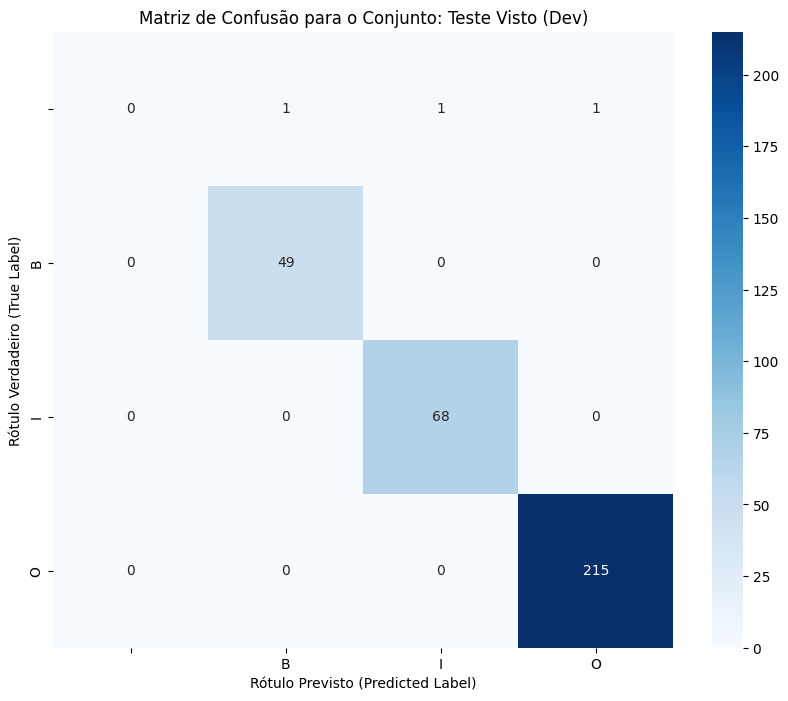


==================== AVALIANDO CONJUNTO: TESTE NÃO VISTO ====================

--- Métricas Gerais (spaCy Scorer) ---
Precisão (P): 0.922
Recall (R): 0.940
F-Score (F1): 0.931

--- Desempenho por Tipo de Entidade ---


,p,r,f
categoria_produto,0.851852,0.884615,0.867925
produto_especifico,1.000000,1.000000,1.000000



--- Relatório de Classificação Detalhado (Tags IOB) ---
              precision    recall  f1-score   support

           B       0.92      0.94      0.93        50
           I       0.97      0.97      0.97        59
           O       0.99      0.98      0.99       239

    accuracy                           0.97       348
   macro avg       0.96      0.96      0.96       348
weighted avg       0.97      0.97      0.97       348


--- Matriz de Confusão (Tags IOB) ---


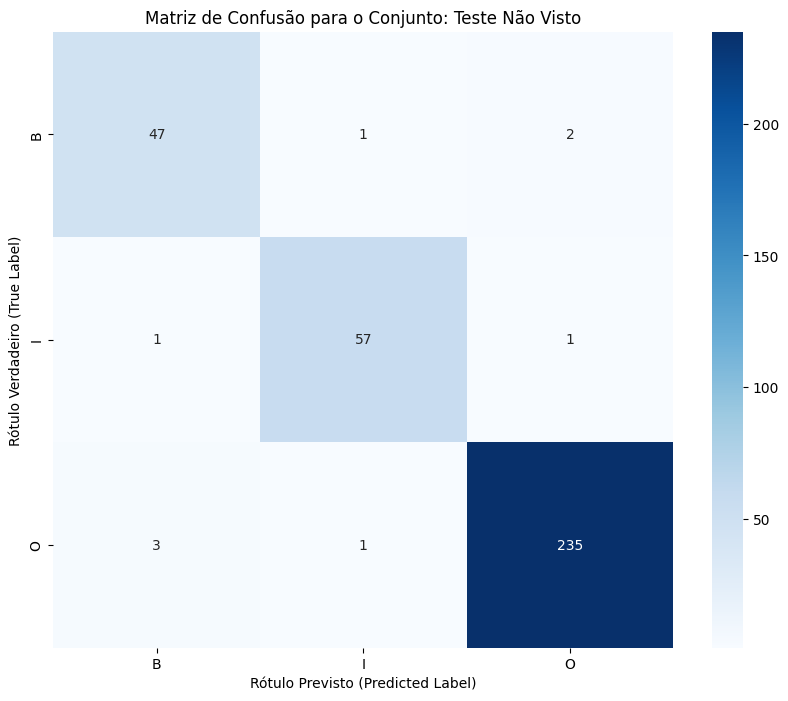

In [13]:
import spacy
from spacy.training.example import Example
from spacy.scorer import Scorer
from spacy.training import iob_utils
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. CARREGAR O MODELO JÁ TREINADO ---
DIRETORIO_SAIDA = f"../models/{dataset.replace('.json', '_finetuned_correto')}"
nlp_treinado = spacy.load(DIRETORIO_SAIDA)

# --- 2. FUNÇÃO DE AVALIAÇÃO ROBUSTA (CORRIGIDA) ---
def avaliar_e_exibir_resultados(nlp_model, dados_para_teste, nome_do_conjunto):
    """
    Executa uma avaliação completa em um conjunto de dados, exibindo métricas,
    relatório de classificação e matriz de confusão.
    """
    print(f"\n{'='*20} AVALIANDO CONJUNTO: {nome_do_conjunto.upper()} {'='*20}")
    
    # Usamos a mesma função de conversão das células anteriores
    dados_formatados = converter_para_formato_spacy(dados_para_teste)
    if not dados_formatados:
        print("Nenhum dado válido para avaliação neste conjunto.")
        return

    scorer = Scorer()
    examples = []
    y_true_iob = []
    y_pred_iob = []

    for text, annotations in dados_formatados:
        doc_pred = nlp_model(text)
        example = Example.from_dict(doc_pred, annotations)
        examples.append(example)
        
        # ===================================================================
        # CORREÇÃO APLICADA AQUI:
        # Extraímos a lista de tags IOB de cada token antes de converter.
        # ===================================================================
        gold_tags = [token.ent_iob_ for token in example.reference]
        pred_tags = [token.ent_iob_ for token in example.predicted]

        y_true_iob.extend(iob_utils.biluo_to_iob(gold_tags))
        y_pred_iob.extend(iob_utils.biluo_to_iob(pred_tags))

    scores = scorer.score(examples)
    print(f"\n--- Métricas Gerais (spaCy Scorer) ---")
    print(f"Precisão (P): {scores['ents_p']:.3f}")
    print(f"Recall (R): {scores['ents_r']:.3f}")
    print(f"F-Score (F1): {scores['ents_f']:.3f}")

    print(f"\n--- Desempenho por Tipo de Entidade ---")
    df_per_type = pd.DataFrame(scores.get('ents_per_type', {})).T.sort_index()
    if not df_per_type.empty:
        display(df_per_type)
    else:
        print("Nenhuma entidade foi detectada ou anotada neste conjunto.")
        
    labels_presentes = sorted(list(set(y_true_iob) | set(y_pred_iob)))
    
    if not labels_presentes:
        print("Não foi possível gerar Relatório de Classificação ou Matriz de Confusão.")
        return

    print(f"\n--- Relatório de Classificação Detalhado (Tags IOB) ---")
    print(classification_report(y_true_iob, y_pred_iob, labels=labels_presentes, zero_division=0))

    print(f"\n--- Matriz de Confusão (Tags IOB) ---")
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true_iob, y_pred_iob, labels=labels_presentes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels_presentes, yticklabels=labels_presentes)
    plt.title(f'Matriz de Confusão para o Conjunto: {nome_do_conjunto}')
    plt.ylabel('Rótulo Verdadeiro (True Label)')
    plt.xlabel('Rótulo Previsto (Predicted Label)')
    plt.show()

# --- 3. EXECUÇÃO DAS AVALIAÇÕES NOS 3 CONJUNTOS ---
# (Você pode descomentar a linha do 'Treino' se quiser ver o desempenho nos dados de treino)
# avaliar_e_exibir_resultados(nlp_treinado, dados_treino, "Treino")
avaliar_e_exibir_resultados(nlp_treinado, dados_dev, "Teste Visto (Dev)")
avaliar_e_exibir_resultados(nlp_treinado, dados_teste_nao_visto, "Teste Não Visto")

*   **As Colunas:**
    *   **p (Precisão):** De tudo que o modelo **afirmou** ser um `produto`, quanto ele acertou. Mede a **exatidão**.
    *   **r (Recall):** De todos os `produtos` que **realmente existiam**, quantos o modelo conseguiu **encontrar**. Mede a **abrangência**.
    *   **f (F1-Score):** A **média harmônica** entre as duas. É a melhor métrica única para avaliar o desempenho geral daquela entidade.

 **começa**, **continua** e **termina**.

*   **B** (Beginning): Marca a **primeira** palavra da entidade. (Ex: "**fone**")
*   **I** (Inside): Marca as palavras do **meio** da entidade. (Ex: "**de ouvido**")
*   **O** (Outside): Marca qualquer palavra **fora** de uma entidade. (Ex: "**quero**, **um**")

Sem isso, o modelo não saberia que "fone de ouvido" é uma coisa só.